# Printing and Plotting Results

Contains two sections:
1. How to create a summary table.
2. How to create plots showing the ranks of the similarity measures.

## Summary Table

This section of the notebook, creates the overview table in our paper. This code can be easily adjusted to also output more detailed tables.

In [1]:
import re
from pathlib import Path

import pandas as pd
import pandas.io.formats.style

from repsim.benchmark.paths import BASE_PATH


measure_to_abbrv = {
    "AlignedCosineSimilarity": "AlignCos",
    "CKA": "CKA",
    "ConcentricityDifference": "ConcDiff",
    "DistanceCorrelation": "DistCorr",
    "EigenspaceOverlapScore": "EOS",
    "GeometryScore": "GS",
    "Gulp": "GULP",
    "HardCorrelationMatch": "HardCorr",
    "IMDScore": "IMD",
    "JaccardSimilarity": "Jaccard",
    "LinearRegression": "LinReg",
    "MagnitudeDifference": "MagDiff",
    "OrthogonalAngularShapeMetricCentered": "AngShape",
    "OrthogonalProcrustesCenteredAndNormalized": "OrthProc",
    "PWCCA": "PWCCA",
    "PermutationProcrustes": "PermProc",
    "ProcrustesSizeAndShapeDistance": "ProcDist",
    "RSA": "RSA",
    "RSMNormDifference": "RSMDiff",
    "RankSimilarity": "RankSim",
    "SVCCA": "SVCCA",
    "SecondOrderCosineSimilarity": "2nd-Cos",
    "SoftCorrelationMatch": "SoftCorr",
    "UniformityDifference": "UnifDiff"
}


2024-06-12 10:06:44.077 | WARNING  | repsim.benchmark.paths:get_experiments_path:17 - No 'DATA_RESULTS_FOLDER' Env variable -- Defaulting to '<project_root>/experiments' .


Step 1: Load all results.

In [2]:
cleaned_dfs = []
nlp_root = BASE_PATH /"paper_results" / "nlp"
for path in nlp_root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    setting = path.name.split("_")[0]

    pattern = r'(?<=_)sst2(?=_)|(?<=_)mnli(?=_)'
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
nlp_data = data


In [3]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"graph"
for path in root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    pattern = r"augmentation|label_test|layer_test|output_correlation|shortcut"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "augmentation": "aug",
        "label_test": "mem",
        "layer_test": "mono",
        "output_correlation": "correlation",
        "shortcut": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)cora(?=_)|(?<=_)flickr(?=_)|(?<=_)ogbn-arxiv(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
graph_data = data

In [4]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"vision"
for path in root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    pattern = r"aug|mem|mono|correlation|sc"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "aug": "aug",
        "mem": "mem",
        "mono": "mono",
        "correlation": "correlation",
        "sc": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)in100(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
vision_data = data

Step 2: Combine data into a big dataframe, clean up column names etc., and select data to be shown in table.

In [5]:
# ----------------------------------------------------------------------------------------------------------------------
# Combine data
# ----------------------------------------------------------------------------------------------------------------------
data = pd.concat([nlp_data, graph_data, vision_data])
print(data.columns)

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

# ----------------------------------------------------------------------------------------------------------------------
# Exclude data not to be shown in table.
# ----------------------------------------------------------------------------------------------------------------------
idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] != "JSD")
data = data.loc[~idx]

idx = (data.Setting.isin(["aug", "mem", "sc"])) & (data["Quality Measure"] != "AUPRC")
data = data.loc[~idx]

idx = (data.Setting.isin(["correlation", "acc_corr"])) & (data["Quality Measure"] != "spearmanr")
data = data.loc[~idx]

idx = (data.Setting.isin(["mono"])) & (data["Quality Measure"] != "correlation")
data = data.loc[~idx]


# ----------------------------------------------------------------------------------------------------------------------
# Clean up names etc.
# ----------------------------------------------------------------------------------------------------------------------


def beautify_df(data):
    data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
        measure_to_abbrv
    )
    data.loc[:, "architecture"] = data["architecture"].map(
        {
            "BERT-L": "BERT",
            "GCN": "GCN",
            "GAT": "GAT",
            "GraphSAGE": "SAGE",
            "VGG11": "VGG11",
            "VGG19": "VGG19",
            "ResNet18": "RNet18",
            "ResNet34": "RNet34",
            "ResNet101": "RNet101",
            "ViT_B32": "ViT_B32",
            "ViT_L32": "ViT_L32",
        }
    )
    data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
    data.loc[:, "Dataset"] = data["Dataset"].map(
        {
            "mnli_aug_rate0": "MNLI",
            "mnli_mem_rate0": "MNLI",
            "mnli": "MNLI",
            "sst2_sc_rate0558": "SST2",
            "sst2_mem_rate0": "SST2",
            "mnli_sc_rate0354": "MNLI",
            "sst2_aug_rate0": "SST2",
            "sst2": "SST2",
            "flickr": "flickr",
            "ogbn-arxiv": "arXiv",
            "cora": "Cora",
            "in100": "IN100",
        }
    )
    data.loc[:, "Setting"] = data["Setting"].map(
        {
            "aug": "Augmentation",
            "mem": "Random Labels",
            "correlation": "JSD Corr.",
            "acc_corr": "Acc Corr.",
            "mono": "Layer Mono.",
            "sc": "Shortcuts",
        }
    )
    column_order = ["Acc Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
    data.loc[:, "Setting"] = pd.Categorical(
        data["Setting"],
        categories=column_order,
        ordered=True,
    )
    data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
        {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
    )
    data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
        1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
    )  # must be run in conjunction with the above renaming

    data = data.rename(
        columns={
            "domain": "Domain",
            "architecture": "Arch.",
            "Representational Similarity Measure": "Sim Meas.",
            "Quality Measure": "Eval.",
            "Setting": "Test",
        }
    )
    data.loc[data.Test.isin(["Acc Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
    data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
    return data, column_order


data, column_order = beautify_df(data)

# ----------------------------------------------------------------------------------------------------------------------
# Create aggregated overview table
# ----------------------------------------------------------------------------------------------------------------------
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"])

pivot = pd.pivot_table(
    data.loc[idx],
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

Index(['similarity_measure', 'quality_measure', 'value', 'domain',
       'architecture', 'representation_dataset', 'identifier', 'Setting',
       'Dataset', 'functional_similarity_measure', 'corr', 'pval', 'model'],
      dtype='object')


Type      Grounding by Prediction                                          \
Test                    Acc Corr.                     JSD Corr.             
Eval.                    Spearman                      Spearman             
Domain                      Graph      Text    Vision     Graph      Text   
Dataset                    flickr      MNLI     IN100    flickr      MNLI   
Arch.                        SAGE      BERT    RNet18      SAGE      BERT   
Sim Meas.                                                                   
2nd-Cos                 -0.088933 -0.255661 -0.078977  0.153887  0.162846   
AlignCos                 0.388142  0.245970 -0.077461  0.443083  0.365349   
AngShape                 0.426746  0.275505  0.207265  0.625955  0.264032   
CKA                      0.372069  0.178528  0.356517  0.576416  0.296706   
ConcDiff                -0.059552 -0.001253 -0.106006 -0.033992  0.021212   
DistCorr                 0.359684  0.153476  0.309447  0.430698  0.392358   
EOS                      0.224374  0.027293  0.048059  0.384585  0.363109   
GULP                     0.215020 -0.009559  0.022282  0.383136  0.345191   
HardCorr                 0.322793  0.043116  0.210166  0.504743 -0.265744   
IMD                      0.369775 -0.262979  0.156438  0.306983 -0.385771   
Jaccard                  0.073518 -0.210964 -0.113982  0.421476  0.125560   
LinReg                   0.276629  0.178544  0.184734  0.477316  0.281074   
MagDiff                 -0.005929  0.217886 -0.161382  0.056126  0.011858   
OrthProc                 0.426746  0.275505  0.208847  0.625955  0.264032   
PWCCA                         NaN  0.013866 -0.022328       NaN  0.220167   
PermProc                -0.040711  0.087418  0.070011 -0.098814 -0.062055   
ProcDist                 0.012780  0.280582  0.079966 -0.179842  0.074177   
RSA                      0.300132  0.003956  0.056233  0.630435  0.268248   
RSMDiff                 -0.160611  0.300623  0.086822 -0.042029 -0.176285   
RankSim                  0.143742 -0.087022  0.071132  0.296970  0.083267   
SVCCA                   -0.119236  0.318225  0.294944  0.231621  0.466930   
SoftCorr                 0.307905  0.114250  0.268838  0.525165 -0.228458   
UnifDiff                 0.007115  0.141609 -0.184076  0.016337 -0.016733   

Type                Grounding by Design                                \
Test                      Random Labels                     Shortcuts   
Eval.                             AUPRC                         AUPRC   
Domain       Vision               Graph      Text    Vision     Graph   
Dataset       IN100              flickr      MNLI     IN100    flickr   
Arch.        RNet18                SAGE      BERT    RNet18      SAGE   
Sim Meas.                                                               
2nd-Cos   -0.127009            0.423219  0.386772  0.712253  1.000000   
AlignCos   0.075889            0.423206  1.000000  0.724314  1.000000   
AngShape   0.243874            0.433875  0.900161  0.724314  1.000000   
CKA        0.299078            0.657255  0.752692  1.000000  1.000000   
ConcDiff  -0.292885            0.569848  1.000000  0.988889  0.176244   
DistCorr   0.260211            0.427352  0.750119  1.000000  1.000000   
EOS        0.086561            0.424426  0.616949  0.837241  0.432888   
GULP       0.070619            0.424274  0.611046  0.892925  0.432888   
HardCorr   0.282872            0.457124  0.749357  0.724314  1.000000   
IMD       -0.102108            0.335412  0.727688  1.000000  0.967215   
Jaccard    0.355995            0.430100  0.685921  1.000000  0.827864   
LinReg     0.213432            0.449161  0.569724       NaN  0.609064   
MagDiff   -0.383004            0.717565  0.331188  1.000000  0.782998   
OrthProc   0.242292            0.433875  0.900161  0.724314  1.000000   
PWCCA      0.130147                 NaN  0.649802       NaN       NaN   
PermProc   0.178788            0.904040  0.436244  0.698892  1.000000   
ProcDist  

Step 3: Convert into latex table.

In [6]:
styled = pd.io.formats.style.Styler(
    pivot,
    precision=2,
)

# Highlight top value
latex_str = styled.highlight_max(axis=0, props="textbf:--rwrap;").to_latex(
    hrules=True,
    position="t",
    label="tab:result_overview",
)


# ----- Manual modifications --------
latex_str = latex_str.split("\n")

# Center headers
pattern = r"\{r\}"
replacement = r"{c}"
latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

# Remove measure row
latex_str.pop(11)

# Add vertical bars
line_no = 3
mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
latex_str[line_no] = mod_line

# Make every second row gray
latex_str = [
    r"\rowcolor{Gray}" + line if i >= 12 and (i - 12) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
] + latex_str[-4:]
latex_str = "\n".join(latex_str)
print(latex_str)

\begin{table}[t]
\label{tab:result_overview}
\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule|rrr|rrr|rrr|rrr|rrr|rrr}
Type & \multicolumn{6}{r}{Grounding by Prediction} & \multicolumn{12}{r}{Grounding by Design} \\
Test & \multicolumn{3}{c}{Acc Corr.} & \multicolumn{3}{c}{JSD Corr.} & \multicolumn{3}{c}{Random Labels} & \multicolumn{3}{c}{Shortcuts} & \multicolumn{3}{c}{Augmentation} & \multicolumn{3}{c}{Layer Mono.} \\
Eval. & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{Spearman} \\
Domain & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision \\
Dataset & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 \\
Arch. & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE &

## Rankplots

Requires section above to be run as well.

In [7]:
import seaborn as sns

sns.set_theme("paper", style="white", font_scale=1.5)


Combine data similarly to before, but do not filter out specific parts.

In [8]:
data = pd.concat([nlp_data, graph_data, vision_data])
data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)
data = data.reset_index()

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = data["Quality Measure"].isin(["AUPRC", "spearmanr", "correlation"])
data = data.loc[idx]

idx = data.Setting == "correlation"
data.loc[idx, "Setting"] = data.loc[idx, "Setting"] + data.loc[idx, "Functional Similarity Measure"]

idx = ~(data.Setting == "mono")
data.loc[idx, "model"] = "agg"


data["rank"] = data.groupby(["domain", "Setting", "Dataset", "architecture", "model"], as_index=True)["value"].rank(
    ascending=False
)
data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(measure_to_abbrv)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Language", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlationJSD": "JSD Corr.",
        "correlationAbsoluteAccDiff": "Acc Corr.",
        "correlationDisagreement": "Disagr. Corr.",
        "acc_corr": "Acc Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)

data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Scenario",
    }
)

data = data.sort_values(by=["Sim Meas."])

Rank measures.

In [9]:
avg_ranks = data.groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Modality,Sim Meas.,avg_rank,med_rank
0,Graph,2nd-Cos,7.934343,7.0
1,Graph,AlignCos,12.131313,11.0
2,Graph,AngShape,9.434343,9.0
3,Graph,CKA,11.005051,10.0
4,Graph,ConcDiff,17.449495,19.0
...,...,...,...,...
63,Vision,RSMDiff,15.876147,17.0
64,Vision,RankSim,8.599099,8.5
65,Vision,SVCCA,15.459091,16.0
66,Vision,SoftCorr,13.288288,14.5


Create plots.

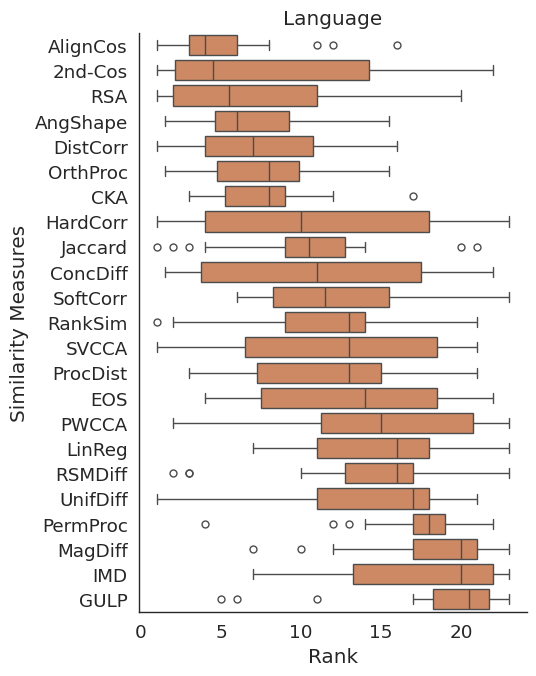

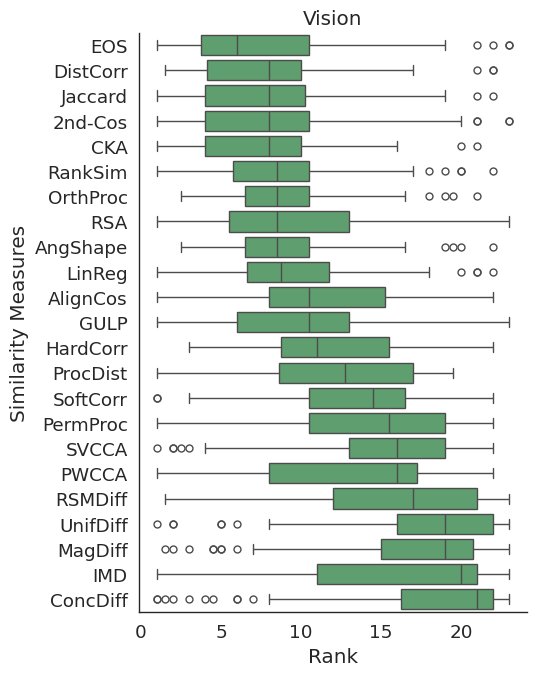

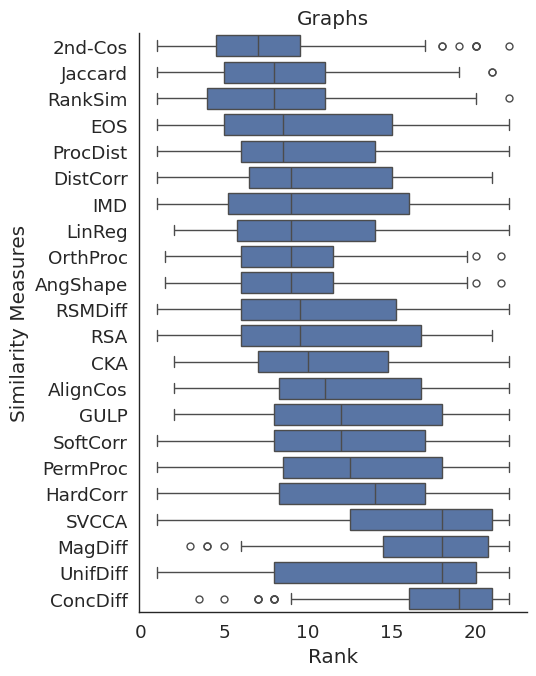

In [10]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
for mod in plot_data.Modality.unique():
    g = sns.catplot(
        data=plot_data[plot_data.Modality == mod],
        x="rank",
        y="Sim Meas.",
        hue="Modality",
        kind="box",
        height=7,
        aspect=0.8,
        col="Modality",
        palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        legend=False
    )
    ax = g.axes[0, 0]
    ax.set_xlabel("Rank")
    ax.set_ylabel("Similarity Measures")
    if mod == "Graph":
        ax.set_title("Graphs")
    else:
        ax.set_title(mod)
    g.savefig(BASE_PATH / ".." / "figures" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")